In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense,Flatten,Dropout, BatchNormalization,Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# Load dataset and Create Training and testing sets

In [2]:

DATASET_PATH = 'Datasets/15-Scene/15-Scene/'
directories = os.listdir(DATASET_PATH)
ONE_HOT_ENCODED = np.eye(len(directories))
FEATURES = []
LABELS = []
for category in sorted(directories):
    path = DATASET_PATH+category
    files = os.listdir(path)
    for fileName in files:
        imgPath = path+"/"+fileName
        img = cv2.imread(imgPath)
        img = cv2.resize(img, (32,32))
        #img = np.reshape(img,[32,32,3])
        FEATURES.append(img)
        LABELS.append((np.reshape(ONE_HOT_ENCODED[int(category)], [15])))


In [3]:
# Randomly shuffle the datasets
shuffle_indices = np.random.permutation(len(FEATURES))
FEATURES = np.array(FEATURES)
LABELS = np.array(LABELS)
FEATURES = FEATURES[shuffle_indices]
LABELS = LABELS[shuffle_indices]

In [4]:
TEST_PERCENTAGE = 0.3 # 30% for testing and 70% for training
train_X = FEATURES[:int(len(FEATURES)*(1-TEST_PERCENTAGE))]
train_y = LABELS[:int(len(LABELS)*(1-TEST_PERCENTAGE))]
print(train_X.shape)

(3139, 32, 32, 3)


In [5]:
test_X = FEATURES[int(len(FEATURES)*(1-TEST_PERCENTAGE)):]
test_y = LABELS[int(len(LABELS)*(1-TEST_PERCENTAGE)):]
print(test_X.shape)

(1346, 32, 32, 3)


# Define Hyperparameters

In [6]:
isAugmentation = True
activation='elu'
batch_size = 64
epochs = 150
num_classes = 15
INITIALIZER = tf.keras.initializers.HeNormal()
SAVE_DIR = os.path.join(os.getcwd(),'models')
MODEL_NAME='ASSIGNMENT_2_PART_2.h5'

# Data preprocessing and augmentation

In [7]:
train_X = train_X.astype('float32')
train_y = train_y.astype('float32')
test_X = test_X.astype('float32')
test_y = test_y.astype('float32')
train_X /= 255.0
test_X /= 255.0

In [8]:
def dataAugmentation(isAugmentation=False):
    if not isAugmentation:
        return None
    else:
        dataGenerator =  ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
        return dataGenerator
        

# Define Model

In [20]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='elu',padding='same',kernel_initializer=INITIALIZER, input_shape=(32, 32, 3)))
model.add(BatchNormalization())
#model.add(Conv2D(32,(3,3),activation='elu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), activation='elu',padding='same'))
model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), activation='elu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='elu',padding='same'))
model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), activation='elu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(15,activation='softmax'))

In [21]:
train_X.shape[1:]

(32, 32, 3)

# Define Optimizer

In [31]:
opt = tf.keras.optimizers.SGD(learning_rate=0.005)

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [33]:
dataGenerator = dataAugmentation(True)

In [34]:
if dataGenerator is not None:
    dataGenerator.fit(train_X)
    history = model.fit(dataGenerator.flow(train_X, train_y,
                                     batch_size=batch_size), epochs=epochs,
                        validation_data=(test_X, test_y))
else:
    history = model.fit(train_X,train_y, batch_size=batch_size,epochs=epochs,validation_data=(test_X,test_y))

Epoch 1/150
50/50 [==============================] - 21s 396ms/step - loss: 1.5000 - accuracy: 0.5116 - val_loss: 2.5158 - val_accuracy: 0.3603
Epoch 2/150
50/50 [==============================] - 20s 391ms/step - loss: 1.4242 - accuracy: 0.5527 - val_loss: 1.2751 - val_accuracy: 0.5684
Epoch 3/150
50/50 [==============================] - 20s 393ms/step - loss: 1.3783 - accuracy: 0.5543 - val_loss: 1.4416 - val_accuracy: 0.5416
Epoch 4/150
50/50 [==============================] - 19s 389ms/step - loss: 1.3598 - accuracy: 0.5486 - val_loss: 2.0091 - val_accuracy: 0.4309
Epoch 5/150
50/50 [==============================] - 19s 388ms/step - loss: 1.3214 - accuracy: 0.5779 - val_loss: 1.4951 - val_accuracy: 0.5520
Epoch 6/150
50/50 [==============================] - 20s 392ms/step - loss: 1.3816 - accuracy: 0.5553 - val_loss: 3.2497 - val_accuracy: 0.3091
Epoch 7/150
50/50 [==============================] - 20s 395ms/step - loss: 1.3049 - accuracy: 0.5687 - val_loss: 1.5362 - val_accuracy:

50/50 [==============================] - 19s 387ms/step - loss: 1.0801 - accuracy: 0.6432 - val_loss: 1.7451 - val_accuracy: 0.5015
Epoch 58/150
50/50 [==============================] - 19s 386ms/step - loss: 1.0103 - accuracy: 0.6604 - val_loss: 1.1369 - val_accuracy: 0.6434
Epoch 59/150
50/50 [==============================] - 19s 389ms/step - loss: 1.1392 - accuracy: 0.6266 - val_loss: 1.0863 - val_accuracy: 0.6486
Epoch 60/150
50/50 [==============================] - 20s 392ms/step - loss: 1.0600 - accuracy: 0.6489 - val_loss: 1.2657 - val_accuracy: 0.5958
Epoch 61/150
50/50 [==============================] - 20s 398ms/step - loss: 1.0293 - accuracy: 0.6508 - val_loss: 1.0837 - val_accuracy: 0.6516
Epoch 62/150
50/50 [==============================] - 21s 422ms/step - loss: 1.0284 - accuracy: 0.6579 - val_loss: 1.3222 - val_accuracy: 0.5736
Epoch 63/150
50/50 [==============================] - 24s 472ms/step - loss: 1.0241 - accuracy: 0.6496 - val_loss: 1.2010 - val_accuracy: 0.620

50/50 [==============================] - 19s 387ms/step - loss: 0.8976 - accuracy: 0.6932 - val_loss: 1.0717 - val_accuracy: 0.6434
Epoch 114/150
50/50 [==============================] - 19s 383ms/step - loss: 0.9048 - accuracy: 0.6923 - val_loss: 1.2814 - val_accuracy: 0.5973
Epoch 115/150
50/50 [==============================] - 19s 389ms/step - loss: 0.8541 - accuracy: 0.7056 - val_loss: 1.2734 - val_accuracy: 0.6092
Epoch 116/150
50/50 [==============================] - 19s 385ms/step - loss: 0.8822 - accuracy: 0.6996 - val_loss: 0.9974 - val_accuracy: 0.6746
Epoch 117/150
50/50 [==============================] - 19s 385ms/step - loss: 0.8603 - accuracy: 0.7177 - val_loss: 1.0909 - val_accuracy: 0.6434
Epoch 118/150
50/50 [==============================] - 19s 383ms/step - loss: 0.8704 - accuracy: 0.7085 - val_loss: 0.9262 - val_accuracy: 0.6872
Epoch 119/150
50/50 [==============================] - 20s 396ms/step - loss: 0.8729 - accuracy: 0.7037 - val_loss: 0.9360 - val_accuracy:

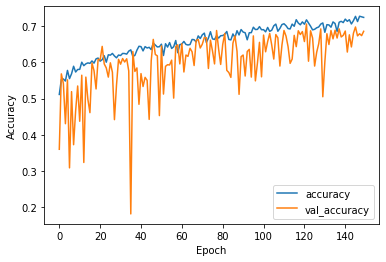

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

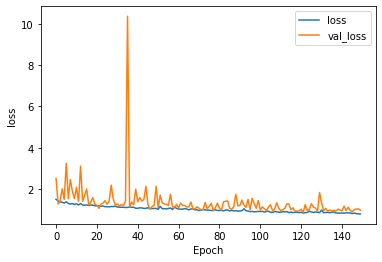

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')